In [1]:
import codecs
from subword_nmt.apply_bpe import BPE

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.init as init
from sklearn.model_selection import KFold
import copy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from utils.load_data import load_ccl, load_AUC_matrix, load_drug
from utils.data_repeat_to_instance import repeat_data
from utils.Mut_Drug_Model import Mut_DrugESPF_Model
from utils.split_data_id import split_id
from utils.create_dataloader import create_dataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density
from utils.tools import get_data_value_range
from utils.plot import loss_curve

In [2]:
import os
print(os.getcwd())

/data3.5T/S312112030/DeepTTA


In [3]:
device = (torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
print(f"Training on device {device}.")

# information
filename     = "ESPF_Train_byCCL_drug_mut_AUC_1fold"
test = False # True:small dataset, False: full dataset

seed = 42
#hyperparameter
model_name = "Mut_DrugESPF_Model"
splitType= 'byCCL'
valueMultiply=1

mut_encode_dim =[1000,100,50] #6009genes
drug_embedding_feature_size = 128
drug_encode_dim =[1600,400,100] # 50*128
mut_encode_dim_save = f'(1000_100_50)'
drug_encode_dim_save= f'(1600_400_100)'
activation_func = nn.ReLU()  # ReLU activation function
activation_func_final = nn.Sigmoid()# sigmoid() or ReLU() # Linear(when -log2AUC)
dense_layer_dim = mut_encode_dim[2]+drug_encode_dim[2] # MLPDim
batch_size = 64
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 150
Decrease_percent = 0.99
continuous = True
learning_rate=1e-05
criterion = nn.MSELoss()

TCGA_pretrain_weight_path = "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt"
dropout_rate = 0

hyperparameter_print = f' model_name ={model_name}\n splitType ={splitType}\n valueMultiply ={valueMultiply}\n mut_encode_dim ={mut_encode_dim}\n drug_encode_dim ={drug_encode_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n dense_layer_dim = {dense_layer_dim}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n dropout_rate ={dropout_rate}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n'
hyperparametersave = f'data*{valueMultiply}_{splitType}_Mut{mut_encode_dim_save}Drug{drug_encode_dim_save}ActF{activation_func}ActFFinl{activation_func_final}MLPDim{dense_layer_dim}BSZ{batch_size}Epoc{num_epoch}Patien{patience}warmup{warmup_iters}Decre%{Decrease_percent}LR{learning_rate}{criterion}DrugEmbSZ{drug_embedding_feature_size}DrpO{dropout_rate}'


Training on device cuda.


In [4]:
#load data
# data_mut, gene_names_mut,ccl_names_mut  = load_ccl("/root/data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt")
ccl_mut_df= pd.read_csv("../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt", sep='\t', index_col=0)
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# data_AUC_matrix, drug_names_AUC, ccl_names_AUC = load_AUC_matrix(splitType,"/root/Winnie/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted.csv") # splitType = "byCCL" or "byDrug" 決定AUCmatrix要不要轉置
print("\n\nDatasets successfully loaded.")
print("drug_df",(np.shape(drug_df)))
print("ccl_mut_df",(np.shape(ccl_mut_df)))
print("AUC_df",np.shape(AUC_df))



Datasets successfully loaded.
drug_df (1440, 9)
ccl_mut_df (476, 6009)
AUC_df (480, 1440)


In [5]:
matched_samples = sorted(set(AUC_df.T.columns) & set(ccl_mut_df.T.columns))
print(len(matched_samples))
AUC_df= (AUC_df.T[matched_samples]).T
print("AUC_df",AUC_df.shape)

476
AUC_df (476, 1440)


In [6]:
if test is True:
    drug_df=drug_df[:42]
    ccl_mut_df=ccl_mut_df[:76]
    AUC_df=AUC_df.iloc[:76,:42]
print(drug_df.shape)
print(ccl_mut_df.shape)
print(AUC_df.shape)

(1440, 9)
(476, 6009)
(476, 1440)


In [7]:
drug_smiles =drug_df["smiles"]
print(drug_smiles.shape)
drug_names =drug_df.index
print((drug_smiles.unique()).shape)
# print(drug_names)

(1440,)
(1440,)


In [8]:
duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
print(duplicate)


Series([], Name: smiles, dtype: object)


In [9]:
def drug2emb_encoder(smile): # drug_smiles['smiles']
    vocab_path = "./dataset/ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./dataset/ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    bpe_codes_drug = codecs.open(vocab_path) # token
    # dbpe: initiate BPE function 
    dbpe = BPE(bpe_codes_drug, merges=-1, separator='') # merges=-1 : no limit on the number of merge operations, and BPE will continue merging subword units until it can no longer find any meaningful merges. 
                                                        #In other words, it will keep merging until the training process converges.
                                                        #separator='' : uses an empty string ('') as a separator between subword units.
    idx2word_d = sub_csv['index'].values # index : substructure EX:CC
    words2idx_d = dict(zip(idx2word_d, range(0, len(idx2word_d))))# zip substructure with it's substructure character length. EX:(CC,2)
    max_d = 50
    t1 = dbpe.process_line(smile).split() # BPE tokenizes the input SMILES # t1=vocabulary set # ex:[ 'Nc1nc(', 'O)', 'c2nc(', 'Br)', 'n(', '[C@@H]3' ]
        # t1: list of subwords of a word
    try:
        i1 = np.asarray([words2idx_d[i] for i in t1]) # i1: subword在sub_csv file中的index ; i: t1中的subword
    except:# 如果t1是空值，或t1中有subword沒有在words2idx_d字典裡
        i1 = np.array([0])
    l = len(i1)
    if l < max_d: # subword list 長度小於50
        i = np.pad(i1, (0, max_d - l), 'constant', constant_values=0) # 補零補到50，前面是s，前面是subword在sub_csv file中的index
        input_mask = ([1] * l) + ([0] * (max_d - l)) # i的mask
    else: # subword list 長度大於等於50
        i = i1[:max_d] # 取前50個subwords(index) # !!!!須改方法!!!!
        input_mask = [1] * max_d # i的mask
    return i, np.asarray(input_mask)

# smile_encode = pd.Series(drug_smiles.unique()).apply(drug2emb_encoder) # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
smile_encode = pd.Series(drug_smiles).apply(drug2emb_encoder)
# uniq_smile_dict = dict(zip(drug_smiles.unique(),smile_encode))# zip drug_smiles和其subword vector編碼 成字典

In [10]:
print(type(smile_encode))
print(smile_encode.shape)
print(type(smile_encode.index))
print((smile_encode.index.values).shape)
print((ccl_mut_df.index.values).shape)


<class 'pandas.core.series.Series'>
(1440,)
<class 'pandas.core.indexes.base.Index'>
(1440,)
(476,)


In [11]:
num_ccl = ccl_mut_df.shape[0]
num_drug = smile_encode.shape[0]
print(num_ccl,num_drug)
# data repeat to instance
# first change data type to torch.float32 and transfer to GPU, then repeat_to_instance byCCL/byDrug

data_mut, data_drug, data_AUC = repeat_data(torch.tensor(ccl_mut_df.values, dtype=torch.float32).to(device=device),
                                            torch.tensor(np.array(smile_encode.values.tolist()), dtype=torch.long).to(device=device),
                                            torch.tensor(AUC_df.values, dtype=torch.float32).to(device=device),
                                            splitType= splitType, num_ccl=num_ccl, num_drug=num_drug, device=device)

476 1440
All inputs are torch.Tensors, added to datalist.
torch.Size([476, 6009])
torch.Size([685440, 6009])
torch.Size([1440, 2, 50])
torch.Size([685440, 2, 50])
torch.Size([476, 1440])
torch.Size([685440])


In [13]:
# randomly split by CCL
# 90% for training(10% for validation) and 10% for testing
id_unrepeat_train, id_unrepeat_val, id_unrepeat_test, id_unrepeat_train_val, id_train, id_val, id_test= split_id(num_ccl=num_ccl,num_drug=num_drug,splitType=splitType,repeat=True,kFold=False)

id_unrepeat_train (387,)
id_unrepeat_val (42,)
id_unrepeat_test (47,)
id_unrepeat_train_val (429,)
id_train.shape (557280,)
id_val.shape (60480,)
id_test.shape (67680,)


In [14]:
#create dataset
seed=42
torch.manual_seed(seed)
train_dataset = create_dataset(data_mut, data_drug, data_AUC, id = id_train, batch_size=batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = create_dataset(data_mut, data_drug, data_AUC, id = id_val, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(data_mut, data_drug, data_AUC, id = id_test, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.48 GiB. GPU 0 has a total capacty of 23.69 GiB of which 7.50 GiB is free. Process 1747190 has 16.18 GiB memory in use. Of the allocated memory 15.86 GiB is allocated by PyTorch, and 28.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
# train
# Init the neural network 
torch.manual_seed(seed)
np.random.seed(seed)

model = Mut_DrugESPF_Model(mut_encode_dim, drug_encode_dim, activation_func, activation_func_final, dense_layer_dim, device,
                        drug_embedding_feature_size,dropout_rate, num_mut_features=data_mut.shape[1], num_drug_features=data_drug.shape[2],
                        TCGA_pretrain_weight_path= TCGA_pretrain_weight_path).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Initialize optimizer

best_epoch, best_weight, best_val_loss, train_epoch_loss_list, val_epoch_loss_list,_ = train( model, activation_func_final,dropout_rate,
    optimizer,      batch_size,      num_epoch,      patience,      warmup_iters,      Decrease_percent,    continuous,
    learning_rate,      criterion,      valueMultiply,      train_loader,      val_loader,
    device,      seed=42, kfoldCV = None)

print("best Epoch : ",best_epoch,"best_val_loss : ",best_val_loss," batch_size : ",batch_size,
        "learning_rate : ",learning_rate," warmup_iters :" ,warmup_iters  ," with Decrease_percent : ",Decrease_percent )

# Saving the model weughts
save_path = f'./results/{filename}_BestValLoss{best_val_loss:.7f}_{hyperparametersave}.pt' # /root/Winnie/PDAC
torch.save(best_weight, save_path)


State_dict loaded successfully.


/data3.5T/S312112030/DeepTTA/utils/Mut_Drug_Model.py:217: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_weight = torch.tensor(mask, dtype=torch.float32).unsqueeze(1).repeat(1, 50, 1)# (bsz, 50)->(bsz,50,50)


Epoch [1/200] - mean_batch Training Loss: 0.02032528
Epoch [1/200] - mean_batch Validation Loss: 0.01265722
lr of epoch 1 => [1e-05]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [2/200] - mean_batch Training Loss: 0.00825646
Epoch [2/200] - mean_batch Validation Loss: 0.00651009
lr of epoch 2 => [1e-05]
Epoch [3/200] - mean_batch Training Loss: 0.00567013
Epoch [3/200] - mean_batch Validation Loss: 0.00474442
lr of epoch 3 => [1e-05]
Epoch [4/200] - mean_batch Training Loss: 0.00493418
Epoch [4/200] - mean_batch Validation Loss: 0.00430202
lr of epoch 4 => [1e-05]
Epoch [5/200] - mean_batch Training Loss: 0.00424502
Epoch [5/200] - mean_batch Validation Loss: 0.00464369
lr of epoch 5 => [1e-05]
Epoch [6/200] - mean_batch Training Loss: 0.00398348
Epoch [6/200] - mean_batch Validation Loss: 0.00387726
lr of epoch 6 => [1e-05]
Epoch [7/200] - mean_batch Training Loss: 0.00395138
Epoch [7/200] - mean_batch Validation Loss: 0.00385569
lr of epoch 7 => [1e-05]
Epoch [8/200] - mean_batch Training Loss: 0.00387625
Epoch [8/200] - mean_batch Validation Loss: 0.00431468
lr of epoch 8 => [1e-05]
Epoch [9/200] - mean_batch Training Loss: 0.00366780
Epoch [9/200] - 

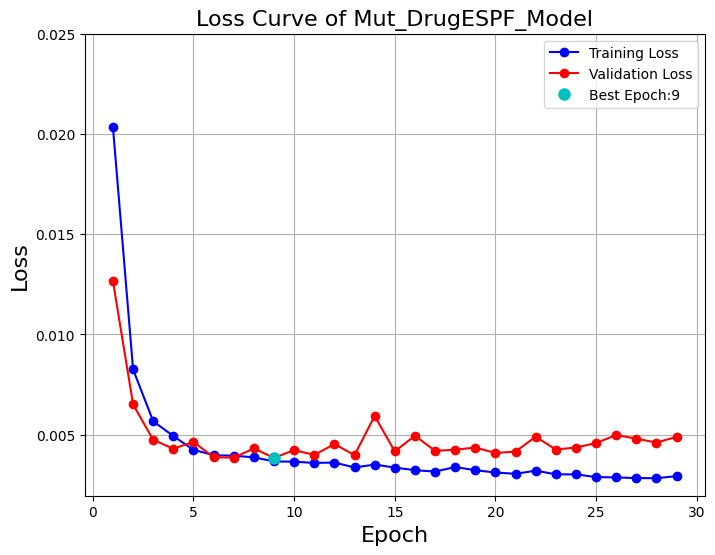

In [17]:
loss_curve(model_name, train_epoch_loss_list, val_epoch_loss_list, best_epoch, best_val_loss, ylim_top=0.025)

In [18]:
# Evaluation
#Evaluation on best fold best split id (train, val) with best_fold_best_weight 
train_dataset = TensorDataset(data_mut[id_train],data_drug[id_train], data_AUC[id_train])
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=False)

# Evaluation on the train set
model.load_state_dict(best_weight)  
model = model.to(device=device)
epoch = None
train_loss, train_targets, train_outputs = evaluation(model, activation_func_final,dropout_rate, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, train_loader, device, correlation='train', kfoldCV = None)
# Evaluation on the validation set
model.load_state_dict(best_weight)  
model = model.to(device=device)
val_loss, val_targets, val_outputs = evaluation(model, activation_func_final,dropout_rate, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, val_loader, device, correlation='val', kfoldCV = None)
# Evaluation on the test set
model.load_state_dict(best_weight)
model = model.to(device=device)
test_loss, test_targets, test_outputs = evaluation(model, activation_func_final,dropout_rate, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, test_loader, device, correlation='test', kfoldCV = None)



Evaluation train Loss: 0.00364014
Evaluation val Loss: 0.00384452
Evaluation test Loss: 0.00345860


len:  19
ACH-000007 : 0.8828377646001526
len:  20
ACH-000008 : 0.9683782151562244
len:  21
ACH-000011 : 0.9465248384055317
len:  15
ACH-000015 : 0.805227903447656
len:  21
ACH-000018 : 0.9573193809096041
len:  20
ACH-000019 : 0.946135791321483
len:  19
ACH-000021 : 0.9273980434809027
len:  18
ACH-000022 : 0.6712921073158744
len:  26
ACH-000023 : 0.9742882709726269
len:  16
ACH-000035 : 0.9534574672020152
len:  18
ACH-000037 : 0.9214181274643929
len:  16
ACH-000042 : 0.9852721262365359
len:  24
ACH-000046 : 0.903701193694254
len:  21
ACH-000048 : 0.9557338155139996
len:  17
ACH-000052 : 0.854023547372079
len:  19
ACH-000054 : 0.9015745339693788
len:  19
ACH-000060 : 0.9286374365746622
len:  22
ACH-000062 : 0.9266640930853778
len:  22
ACH-000066 : 0.9267206623678711
len:  13
ACH-000082 : 0.5926905301853007
len:  13
ACH-000086 : 0.8797712526209942
len:  22
ACH-000090 : 0.9709547306915732
len:  20
ACH-000091 : 0.9511913375448765
len:  16
ACH-000096 : 0.9495328078277777
len:  15
ACH-000098 

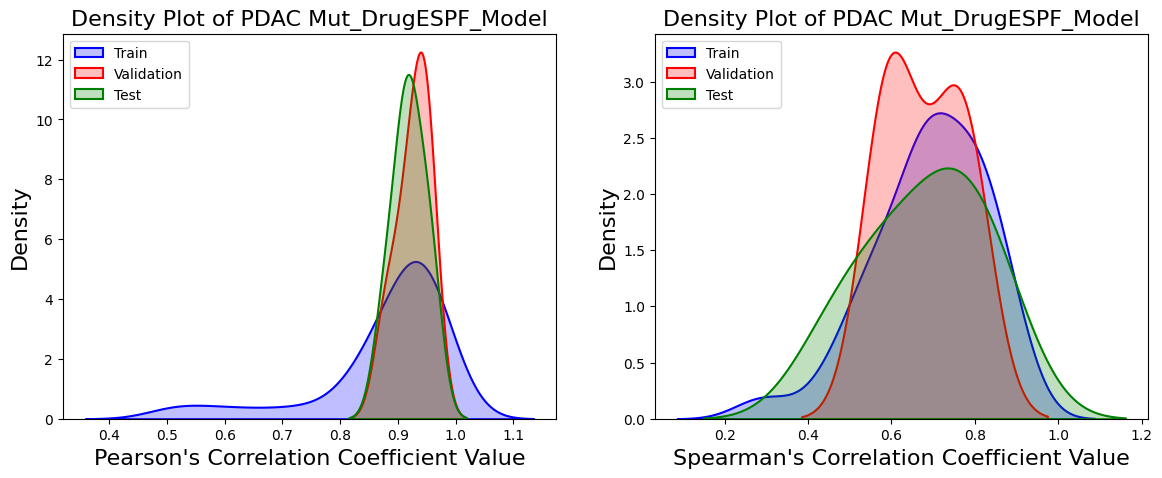

[0.9108710885047913, 0.8986685276031494, 0.5295575857162476, 0.8358186483383179, 0.9319648146629333, 0.8219831585884094, 0.8207923173904419, 0.7792613506317139, 0.927812397480011, 0.8373652100563049]
(1419,)
(1419,)
[0.903644323348999, 0.9385373592376709, 0.512050449848175, 0.8205047249794006, 0.8812506198883057, 0.7088488340377808, 0.7893801331520081, 0.7654202580451965, 0.8884239196777344, 0.7771479487419128]


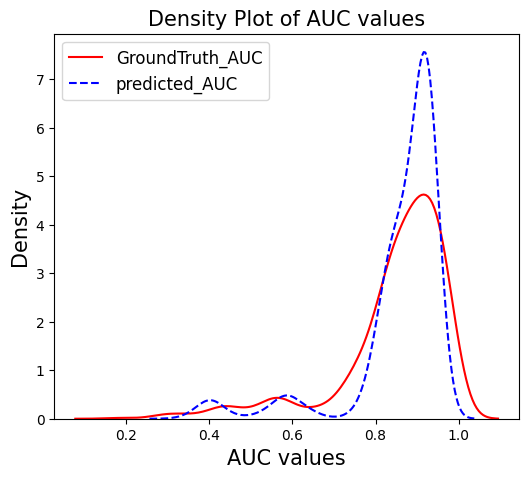

In [19]:
# Correlation
train_pearson, train_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_train,train_targets,train_outputs)
print("\n")
print("val set"+"="*20)
print("val set"+"="*20)
val_pearson, val_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_val,val_targets,val_outputs)
print("\n")
print("test set"+"="*20)
print("test set"+"="*20)
test_pearson, test_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_test,test_targets,test_outputs)

#plot correlation_density
correlation_density(model_name,train_pearson,val_pearson,test_pearson,train_spearman,val_spearman,test_spearman)

# plot GroundTruth AUC and predicted AUC distribution
import seaborn as sns
import matplotlib.pyplot as plt
predicted_AUC = train_outputs + val_outputs + test_outputs
predicted_AUC = np.concatenate(predicted_AUC).tolist()
print(predicted_AUC[:10])
print(np.array(predicted_AUC).shape)
GroundTruth_AUC = train_targets + val_targets + test_targets
GroundTruth_AUC = np.concatenate(GroundTruth_AUC).tolist()
print(np.array(GroundTruth_AUC).shape)
print(GroundTruth_AUC[:10])

fig=plt.figure(figsize=(6, 5))
sns.kdeplot(GroundTruth_AUC, color='red', label='GroundTruth_AUC')
sns.kdeplot(predicted_AUC, color='blue', linestyle='dashed', label='predicted_AUC')
# Set the x-axis label to 'Density'
plt.xlabel('AUC values',fontsize=15)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density',fontsize=15)
# Set the title of the plot
plt.title('Density Plot of AUC values',fontsize=15)
plt.legend(fontsize=12)
plt.show()
fig.savefig('Density Plot of AUC values')

In [20]:
 # data range
get_data_value_range(GroundTruth_AUC,"GroundTruth_AUC")
get_data_value_range(predicted_AUC,"predicted_AUC")

# print hyperparameter and result
print(filename)
print(hyperparameter_print)
print('best epoch: ',best_epoch)

print(f'Evaluation Training Loss: {train_loss:.6f}')
print(f'Evaluation validation Loss: {val_loss:.6f}')
print(f'Evaluation Test Loss: {test_loss:.6f}')

print(f"Mean train_pearson PDAC {model_name}: ",np.mean(train_pearson))
print(f"Median train_pearson PDAC {model_name}: ",np.median(train_pearson))
print(f"Mode train_pearson PDAC {model_name}: ",stats.mode(np.round(train_pearson,2))[0],",count=",stats.mode(np.round(train_pearson,2))[1])

print(f"Mean val_pearson PDAC {model_name}: ",np.mean(val_pearson))
print(f"Median val_pearson PDAC {model_name}: ",np.median(val_pearson))
print(f"Mode val_pearson PDAC {model_name}: ",stats.mode(np.round(val_pearson,2))[0],",count=",stats.mode(np.round(val_pearson,2))[1])

print(f"Mean test_pearson PDAC {model_name}: ",np.mean(test_pearson))
print(f"Median test_pearson PDAC {model_name}: ",np.median(test_pearson))
print(f"Mode test_pearson PDAC {model_name}: ",stats.mode(np.round(test_pearson,2))[0],",count=",stats.mode(np.round(test_pearson,2))[1])

print(f"Mean train_spearman PDAC {model_name}: ",np.mean(train_spearman))
print(f"Median train_spearman PDAC {model_name}: ",np.median(train_spearman))
print(f"Mode train_spearman PDAC {model_name}: ",stats.mode(np.round(train_spearman,2))[0],",count=",stats.mode(np.round(train_spearman,2))[1])

print(f"Mean val_spearman PDAC {model_name}: ",np.mean(val_spearman))
print(f"Median val_spearman PDAC {model_name}: ",np.median(val_spearman))
print(f"Mode val_spearman PDAC {model_name}: ",stats.mode(np.round(val_spearman,2))[0],",count=",stats.mode(np.round(val_spearman,2))[1])

print(f"Mean test_spearman PDAC {model_name}: ",np.mean(test_spearman))
print(f"Median test_spearman PDAC {model_name}: ",np.median(test_spearman))
print(f"Mode test_spearman PDAC {model_name}: ",stats.mode(np.round(test_spearman,2))[0],",count=",stats.mode(np.round(test_spearman,2))[1])

print(f"Mean Median Mode train_pearson PDAC {model_name}: ",np.mean(train_pearson)," ",np.median(train_pearson)," ",stats.mode(np.round(train_pearson,2)))
print(f"Mean Median Mode val_pearson PDAC {model_name}: ",np.mean(val_pearson)," ",np.median(val_pearson)," ",stats.mode(np.round(val_pearson,2)))
print(f"Mean Median Mode test_pearson PDAC {model_name}: ",np.mean(test_pearson)," ",np.median(test_pearson)," ",stats.mode(np.round(test_pearson,2)))
print(f"Mean Median Mode train_spearman PDAC {model_name}: ",np.mean(train_spearman)," ",np.median(train_spearman)," ",stats.mode(np.round(train_spearman,2)))
print(f"Mean Median Mode val_spearman PDAC {model_name}: ",np.mean(val_spearman)," ",np.median(val_spearman)," ",stats.mode(np.round(val_spearman,2)))
print(f"Mean Median Mode test_spearman PDAC {model_name}: ",np.mean(test_spearman)," ",np.median(test_spearman)," ",stats.mode(np.round(test_spearman,2)))


GroundTruth_AUC  : 
Range: 0.82789084
Minimum: 0.17210618
Maximum: 0.99999702
Mean: 0.84615664
Median: 0.88133514
Standard Deviation: 0.13486085
binary data: False
-------------------------------------
predicted_AUC  : 
Range: 0.61647049
Minimum: 0.33853939
Maximum: 0.95500988
Mean: 0.85763382
Median: 0.90010637
Standard Deviation: 0.11763603
binary data: False
-------------------------------------
ESPF_Train_byCCL_drug_mut_AUC_1fold
 model_name =Mut_DrugESPF_Model
 splitType =byCCL
 valueMultiply =1
 mut_encode_dim =[1000, 100, 50]
 drug_encode_dim =[1600, 400, 100]
 activation_func = ReLU()
 activation_func_final = Sigmoid()
 dense_layer_dim = 150
 batch_size = 64
 num_epoch = 200
 patience = 20
 warmup_iters = 150
 Decrease_percent = 0.99
 continuous =True
 learning_rate = 1e-05
 criterion =MSELoss()
 dropout_rate =0
 drug_embedding_feature_size =128

best epoch:  9
Evaluation Training Loss: 0.003640
Evaluation validation Loss: 0.003845
Evaluation Test Loss: 0.003459
Mean train_pear